#Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

import tensorflow as tf
import random as python_random
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Set numpy print options
np.set_printoptions(suppress=True)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/P2/filtered_storms_df.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.columns

Index(['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65',
       'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)',
       'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1',
       'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)',
       'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)',
       'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)',
       'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num',
       'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain'],
      dtype='object')

#Train/test split

In [24]:
# Define input features and target variable
input_columns = [
    'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91',
    'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days',
    'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID'
]
target_column = 'Recession_Rate (mm/s)'

# Define test storm IDs
storm_ids = {12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115,
             200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325,
             326, 214, 205}

# Split into train and test sets
test_df, train_df = df[df['StormID'].isin(storm_ids)], df[~df['StormID'].isin(storm_ids)]

# Extract input and target variables
X_train, y_train = train_df[input_columns], train_df[target_column]
X_test, y_test = test_df[input_columns], test_df[target_column]

# Scale features
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

#Model

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

# Define LSTM parameters
timesteps = 2
features = X_train_scaled.shape[1]
n_samples_train = X_train_scaled.shape[0]
n_samples_test = X_test_scaled.shape[0]

# Initialize reshaped arrays
X_train_reshaped = np.array([X_train_scaled[i - timesteps:i] for i in range(timesteps, n_samples_train)])
X_test_reshaped = np.array([X_test_scaled[i - timesteps:i] for i in range(timesteps, n_samples_test)])

# Adjust target variable (drop initial timesteps)
y_train_adjusted = y_train[timesteps:].reset_index(drop=True)
y_test_adjusted = y_test[timesteps:].reset_index(drop=True)

# Define LSTM model
model = Sequential([
    LSTM(units=32, return_sequences=True, input_shape=(timesteps, features)),
    Dropout(0.3),
    BatchNormalization(),  # Optional but improves stability
    LSTM(units=16),
    Dropout(0.2),
    Dense(units=1)
])

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train model
model.fit(
    X_train_reshaped, y_train_adjusted,
    epochs=30, batch_size=64,
    validation_data=(X_test_reshaped, y_test_adjusted),
    callbacks=[early_stopping],
    verbose=1
)

# Predictions
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Compute R² scores
r2_train = r2_score(y_train_adjusted, y_train_pred)
r2_test = r2_score(y_test_adjusted, y_test_pred)

# Print results
print(f'Train R² Score: {r2_train:.4f}')
print(f'Test R² Score: {r2_test:.4f}')

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0233 - val_loss: 1.7830e-04
Epoch 2/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0012 - val_loss: 1.2425e-04
Epoch 3/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.9645e-04 - val_loss: 1.0839e-04
Epoch 4/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.2568e-04 - val_loss: 8.8690e-05
Epoch 5/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.5100e-04 - val_loss: 7.9755e-05
Epoch 6/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.0845e-04 - val_loss: 7.6999e-05
Epoch 7/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 9.0199e-05 - val_loss: 7.3954e-05
Epoch 8/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 7.5326e-05 - val_loss: 7.7216e-05
Epoch 9/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 8.4547e-05 - val_loss: 7.3864e-05
Epoch 10/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.7264e-05 - val_loss: 6.9862e-05
Epoch 11/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 7.5198e-05 - va

#Predict

In [13]:
# Define evaluation function
def evaluate_predictions(y_true, y_pred, label):
    # Ensure predictions have the same length as y_true
    y_pred = y_pred.flatten()

    if len(y_pred) < len(y_true):
        y_true = y_true.iloc[:len(y_pred)]  # Trim target to match predictions
    elif len(y_pred) > len(y_true):
        y_pred = y_pred[:len(y_true)]  # Trim predictions to match target

    # Compute evaluation metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    # Print results
    print(f"\n📌 {label} Data Evaluation Metrics:")
    print(f"🔹 R-squared (R²): {r2:.4f}")
    print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
    print(f"🔹 Explained Variance Score (EVS): {evs:.4f}")

    return y_true, y_pred

# Ensure consistent lengths before evaluation
y_train_adjusted = y_train[timesteps:].reset_index(drop=True)
y_test_adjusted = y_test[timesteps:].reset_index(drop=True)

# Evaluate Train & Test Data
y_train_clean, y_train_pred_clean = evaluate_predictions(y_train_adjusted, y_train_pred, "Train")
y_test_clean, y_test_pred_clean = evaluate_predictions(y_test_adjusted, y_test_pred, "Test")


📌 Train Data Evaluation Metrics:
🔹 R-squared (R²): 0.7784
🔹 Mean Squared Error (MSE): 0.0000
🔹 Root Mean Squared Error (RMSE): 0.0061
🔹 Mean Absolute Error (MAE): 0.0033
🔹 Explained Variance Score (EVS): 0.7790

📌 Test Data Evaluation Metrics:
🔹 R-squared (R²): 0.7513
🔹 Mean Squared Error (MSE): 0.0001
🔹 Root Mean Squared Error (RMSE): 0.0073
🔹 Mean Absolute Error (MAE): 0.0032
🔹 Explained Variance Score (EVS): 0.7513


1315/1315 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
y_pred_train shape: (42063,)
y_pred_test shape: (17078,)


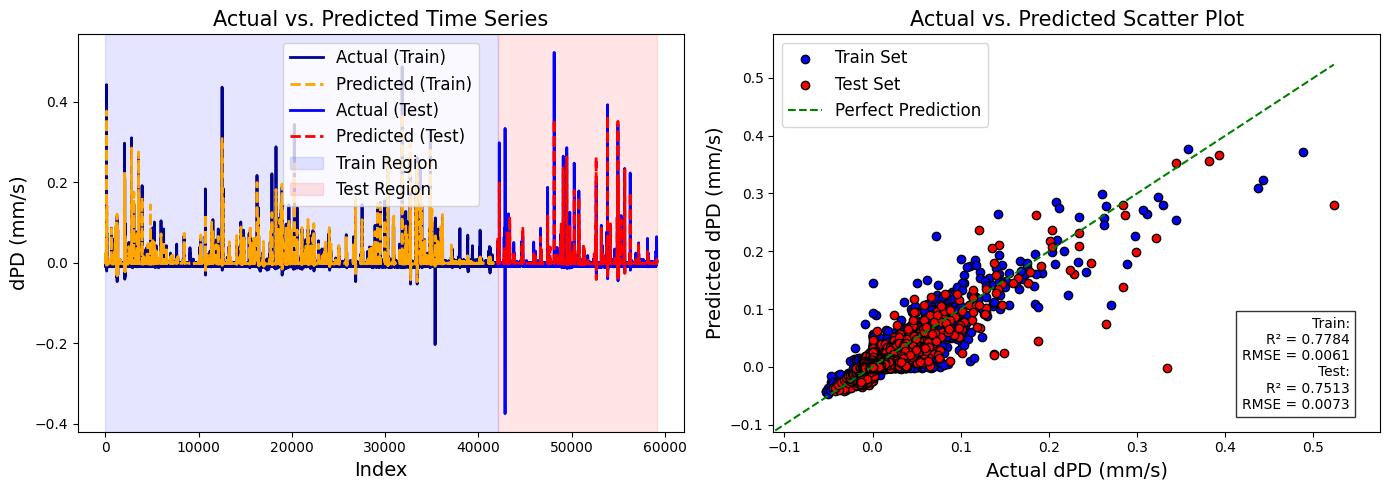

In [17]:
# Ensure predictions exist
y_pred_train = model.predict(X_train_reshaped).flatten()
y_pred_test = model.predict(X_test_reshaped).flatten()

# Compute evaluation metrics
mse_train = mean_squared_error(y_train_adjusted, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_adjusted, y_pred_train)

mse_test = mean_squared_error(y_test_adjusted, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_adjusted, y_pred_test)

# Check shapes before plotting
print("y_pred_train shape:", y_pred_train.shape)
print("y_pred_test shape:", y_pred_test.shape)

# Generate indices
train_index = np.arange(len(y_train_adjusted))
test_index = np.arange(len(y_test_adjusted)) + len(y_train_adjusted)

# Compute min and max for setting axis limits
min_val = min(y_train_adjusted.min(), y_test_adjusted.min())
max_val = max(y_train_adjusted.max(), y_test_adjusted.max())

# Create horizontal subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

### **Subplot 1: Time Series Comparison** ###
axes[0].plot(train_index, y_train_adjusted, label='Actual (Train)', color='darkblue', linewidth=2)
axes[0].plot(train_index, y_pred_train, label='Predicted (Train)', color='orange', linestyle='dashed', linewidth=2)
axes[0].plot(test_index, y_test_adjusted, label='Actual (Test)', color='blue', linewidth=2)
axes[0].plot(test_index, y_pred_test, label='Predicted (Test)', color='red', linestyle='dashed', linewidth=2)

# Highlight train and test regions
axes[0].axvspan(train_index.min(), train_index.max(), color='blue', alpha=0.1, label='Train Region')
axes[0].axvspan(test_index.min(), test_index.max(), color='red', alpha=0.1, label='Test Region')

axes[0].set_xlabel("Index", fontsize=14)
axes[0].set_ylabel("dPD (mm/s)", fontsize=14)
axes[0].legend(fontsize=12)
axes[0].set_title("Actual vs. Predicted Time Series", fontsize=15)

### **Subplot 2: Scatter Plot** ###
slope, intercept, r_value, p_value, std_err = stats.linregress(y_train_adjusted, y_pred_train)

axes[1].scatter(y_train_adjusted, y_pred_train, c='blue', edgecolors='k', label='Train Set')
axes[1].scatter(y_test_adjusted, y_pred_test, c='red', edgecolors='k', label='Test Set')
axes[1].plot(
    [min_val, max_val],
    [min_val, max_val],
    'g--', label='Perfect Prediction'
)

axes[1].set_xlabel("Actual dPD (mm/s)", fontsize=14)
axes[1].set_ylabel("Predicted dPD (mm/s)", fontsize=14)
axes[1].legend(fontsize=12)
axes[1].set_title("Actual vs. Predicted Scatter Plot", fontsize=15)

# Add text box with model evaluation metrics
text_msg = f"Train:\nR² = {r2_train:.4f}\nRMSE = {rmse_train:.4f}\nTest:\nR² = {r2_test:.4f}\nRMSE = {rmse_test:.4f}"
axes[1].text(
    0.95, 0.05, text_msg, ha='right', va='bottom', transform=axes[1].transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Apply the adjusted axis limits
axes[1].set_xlim([min_val * 0.3, max_val * 1.1])
axes[1].set_ylim([min_val * 0.3, max_val * 1.1])

plt.tight_layout()
plt.show()

In [20]:
# Compute residuals
residuals_train = y_train_adjusted - y_train_pred.flatten()
residuals_test = y_test_adjusted - y_test_pred.flatten()

# Compute standard error of residuals
residual_std_train = np.std(residuals_train)
residual_std_test = np.std(residuals_test)

# Confidence level for prediction interval (95%)
confidence_level = 0.95

# Critical value for confidence interval (two-tailed test)
t_critical_train = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals_train) - 2)
t_critical_test = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals_test) - 2)

# Compute margin of error
margin_of_error_train = t_critical_train * residual_std_train
margin_of_error_test = t_critical_test * residual_std_test

# Compute prediction interval bounds
lower_bound_train = y_train_pred.flatten() - margin_of_error_train
upper_bound_train = y_train_pred.flatten() + margin_of_error_train
lower_bound_test = y_test_pred.flatten() - margin_of_error_test
upper_bound_test = y_test_pred.flatten() + margin_of_error_test

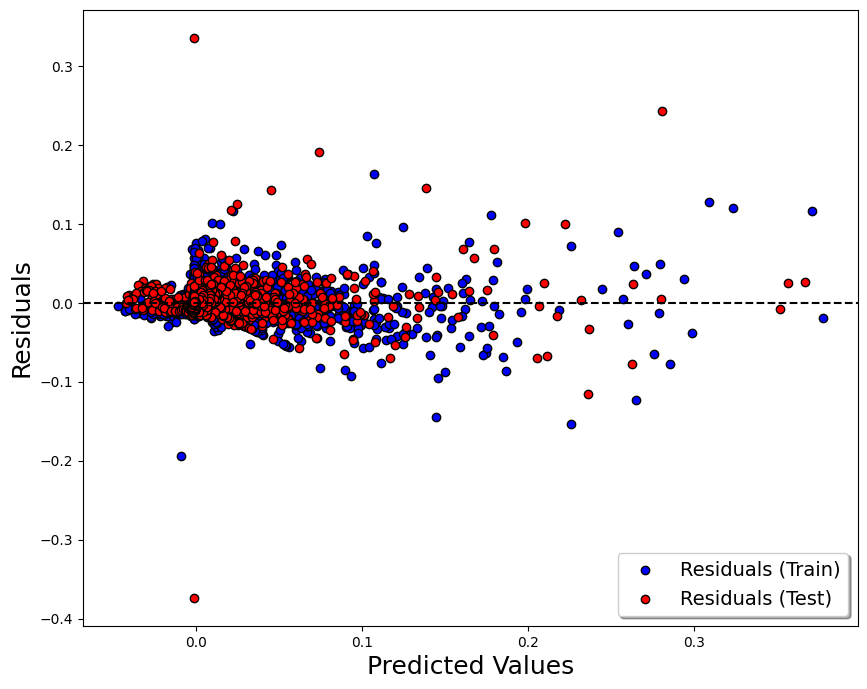

In [22]:
# Compute residuals
residuals_train = y_train_adjusted - y_train_pred.flatten()
residuals_test = y_test_adjusted - y_test_pred.flatten()

def plot_residuals_vs_predicted(y_pred_train, residuals_train, y_pred_test, residuals_test):
    plt.figure(figsize=(10, 8))  # Adjusted figure size for better visibility

    # Training data in blue
    plt.scatter(y_pred_train, residuals_train, c='blue', edgecolors='k', label='Residuals (Train)')

    # Testing data in red
    plt.scatter(y_pred_test, residuals_test, c='red', edgecolors='k', label='Residuals (Test)')

    # Configure labels with increased font sizes
    plt.xlabel("Predicted Values", fontsize=18)
    plt.ylabel("Residuals", fontsize=18)

    # Add a horizontal line at y=0 to represent perfect predictions
    plt.axhline(y=0, color='black', linestyle='--')

    # Add a combined legend for all plot elements on the bottom right
    plt.legend(loc='lower right', fontsize=14, frameon=True, shadow=True)

    # Display the plot
    plt.show()

# Call the function to generate the plot
plot_residuals_vs_predicted(y_train_pred.flatten(), residuals_train, y_test_pred.flatten(), residuals_test)

In [ ]:
import numpy as np

# Assuming y_test and y_pred_test are available and are numpy arrays or similar data structures
residuals = y_test - y_pred_test

# Calculate the quartiles
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Determine the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = [r for r in residuals if r < lower_bound or r > upper_bound]

# Number of outliers
num_outliers = len(outliers)

print("Number of outliers in residuals:", num_outliers)
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)

Number of outliers in residuals: 933
Lower bound for outliers: -0.008454029510765654
Upper bound for outliers: 0.00825375136008822


In [ ]:
# Assuming y_test and y_pred_test are numpy arrays representing your data.
# Here's how you would calculate the percentage of outliers in the residuals:

# Calculate residuals
residuals = y_test - y_pred_test

# Calculate the quartiles
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Determine the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

# Number of outliers
num_outliers = len(outliers)

# Total number of data points
total_data_points = len(residuals)

# Calculate the percentage of outliers
percentage_outliers = (num_outliers / total_data_points) * 100

percentage_outliers

5.462529274004684

Specific storm

In [ ]:
storm_number = 212

In [ ]:
# # Resample the specified columns from 5-minute to 15-minute intervals
# test_storm = test_storm.resample('15T').mean()

In [ ]:
test_storm = df[df['StormID'] ==  storm_number]
# test_storm[["Datetime"]] = test_storm[["Datetime"]].apply(pd.to_datetime)
# test_storm.set_index('Datetime', inplace=True)
# X = test_storm[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)']]

X = test_storm[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']]

y = test_storm['Recession_Rate (mm/s)']
# y = test_storm['Water_Depth (mm)']

X_specific_event = X
y_specific_event = y

# Standardize the input features
scaler_X = StandardScaler()
X_specific_event_scaled = scaler_X.fit_transform(X_specific_event)

# # Convert y_specific_event from Series to numpy array|
# y_specific_event_array = y_specific_event.to_numpy()

import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import StandardScaler

# Reshape the input data to match the expected input shape of the CNN
timesteps = 2  # Number of previous datapoints to consider
features = X_specific_event_scaled.shape[1]
n_samples_test = X_specific_event_scaled.shape[0]

X_specific_event_reshaped = np.zeros((n_samples_test - timesteps + 1, timesteps, features))

for i in range(timesteps, n_samples_test + 1):
    X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]


# Make predictions on the test set
y_pred_specific_event = model.predict(X_specific_event_reshaped)

26/26 [==============================] - 0s 2ms/step


In [ ]:
# Compute R2 score for the test set
r2_test = r2_score(y_specific_event[timesteps-1:], y_pred_specific_event)
print('The test score is R2 = ', r2_test)

The test score is R2 =  0.5237133300113763


In [ ]:
# Pad zeroes to match the dimensions
y_pred_specific_event_padded = np.concatenate((np.zeros(timesteps-1), y_pred_specific_event.flatten()))
# Create dataset for y_specific_event and y_pred_specific_event
test_dataset_storm = np.column_stack((y_specific_event, y_pred_specific_event_padded))

# Convert test_dataset_storm to Pandas DataFrame
df_test_specific_events = pd.DataFrame(test_dataset_storm, columns=['Original Data', 'Predicted Data'])

# Compute R2 score for the test set
r2_test = r2_score(df_test_specific_events['Original Data'], df_test_specific_events['Predicted Data'])
print('The R2 for the test data is:', r2_test)

The R2 for the test data is: 0.5237133305545034


In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(df_test_specific_events['Original Data']) - np.array(df_test_specific_events['Predicted Data']))**2))

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.0082


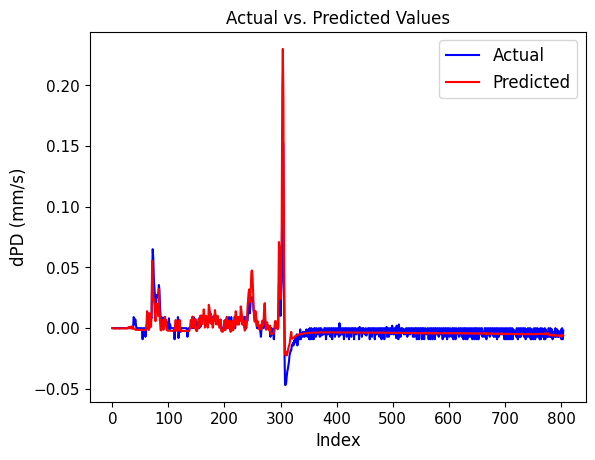

In [ ]:
y_specific_event = df_test_specific_events['Original Data']
y_pred_specific_event = df_test_specific_events['Predicted Data']


import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the actual values in blue
ax.plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')

# Plot the predicted values in red
ax.plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')

# Add labels and legend with fontsize=12
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("dPD (mm/s)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=12)
ax.legend(fontsize=12)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

In [ ]:
test_storm

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
35217,2/10/2018 11:20,7.436,1.4412,0.368,0.397,0.371,0.425,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,10,4,0,0.0,0.0,0.0
35218,2/10/2018 11:25,7.796,1.4468,0.369,0.397,0.372,0.425,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,10,4,0,0.0,0.0,0.0
35219,2/10/2018 11:30,8.250,1.4548,0.367,0.395,0.372,0.425,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,10,4,0,0.0,0.0,0.0
35220,2/10/2018 11:35,8.430,1.4412,0.368,0.396,0.372,0.425,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,10,4,0,0.0,0.0,0.0
35221,2/10/2018 11:40,8.470,1.4492,0.368,0.397,0.372,0.424,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,10,4,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36017,2/13/2018 6:00,-4.336,3.6028,0.383,0.410,0.457,0.425,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,13,4,0,0.0,0.0,0.0
36018,2/13/2018 6:05,-4.336,3.6000,0.384,0.412,0.456,0.426,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,13,4,0,0.0,0.0,0.0
36019,2/13/2018 6:10,-4.309,3.6000,0.385,0.413,0.456,0.425,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,13,4,0,0.0,0.0,0.0
36020,2/13/2018 6:15,-4.490,3.6000,0.384,0.412,0.456,0.426,0.0,0.0,0.0,...,0.000011,0.154432,2018,2,13,4,0,0.0,0.0,0.0


In [ ]:
y_specific_event

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
800   -0.001016
801   -0.009144
802    0.000000
803   -0.009144
804   -0.002032
Name: Original Data, Length: 805, dtype: float64

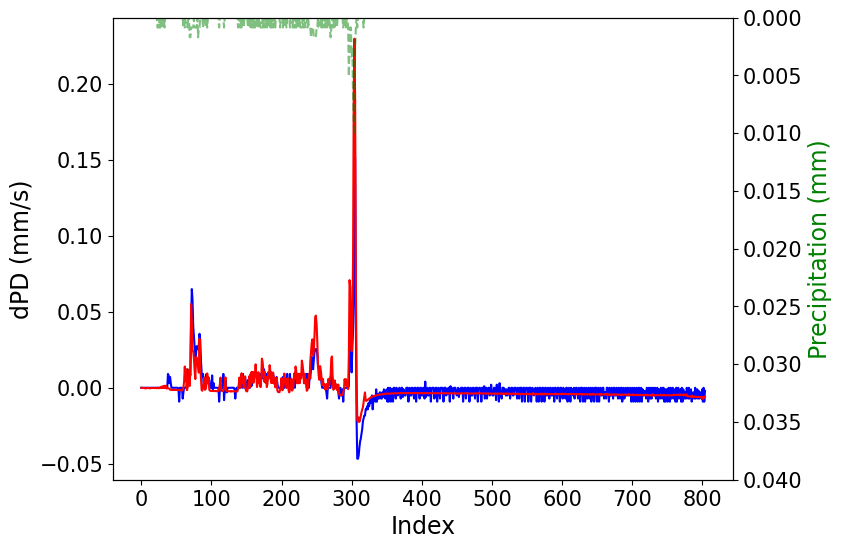

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_specific_event and y_pred_specific_event are defined
# y_specific_event = df_test_specific_events['Original Data']
# y_pred_specific_event = df_test_specific_events['Predicted Data']

# Reset the index of test_storm and reindex 'Precipitation (mm)' starting from 0
precipitation_event = test_storm['Precipitation (mm)'].reset_index(drop=True)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the actual values in blue
ax.plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')

# Plot the predicted values in red
ax.plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')

# Update font sizes
ax.set_xlabel("Index", fontsize=17)
ax.set_ylabel("dPD (mm/s)", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=17)

# Create a secondary y-axis for 'Precipitation'
ax2 = ax.twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.04, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
ax2.plot(precipitation_event.index, precipitation_event, color='green', alpha=0.5, label='Precipitation', linestyle='--')

# Update secondary axis font sizes
ax2.set_ylabel('Precipitation (mm)', fontsize=17, color='green')
ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.85), fontsize=17)

plt.show()

In [ ]:
test_storm['Precipitation (mm)']

35217    0.0
35218    0.0
35219    0.0
35220    0.0
35221    0.0
        ... 
36017    0.0
36018    0.0
36019    0.0
36020    0.0
36021    0.0
Name: Precipitation (mm), Length: 805, dtype: float64

In [ ]:
df_test_specific_events['Predicted Data']

0      0.000000
1     -0.000159
2     -0.000086
3     -0.000120
4     -0.000181
         ...   
800   -0.006556
801   -0.007330
802   -0.005869
803   -0.006458
804   -0.005883
Name: Predicted Data, Length: 805, dtype: float64

In [ ]:
df_test_specific_events['Predicted Data'] = df_test_specific_events['Predicted Data'].apply(lambda x: 0 if x > 0 else x)
df_test_specific_events['Original Data'] = df_test_specific_events['Original Data'].apply(lambda x: 0 if x > 0 else x)

In [ ]:
y_specific_event = df_test_specific_events['Original Data']
y_pred_specific_event = df_test_specific_events['Predicted Data']

In [ ]:
# Compute R2 score for the test set
r2_test = r2_score(df_test_specific_events['Original Data'], df_test_specific_events['Predicted Data'])
print('The R2 for the test data is:', r2_test)

The R2 for the test data is: 0.4788675922840111


In [ ]:
y_specific_event = df_test_specific_events['Original Data']
y_pred_specific_event = df_test_specific_events['Predicted Data']

In [ ]:
# Evaluate the model's performance for this specific event
mse_specific_event = mean_squared_error(y_specific_event, y_pred_specific_event)
r2_specific_event = r2_score(y_specific_event, y_pred_specific_event)

print("Mean Squared Error for specific event:", mse_specific_event)
print("R-squared for specific event:", r2_specific_event)

Mean Squared Error for specific event: 1.3203598774302883e-05
R-squared for specific event: 0.4788675922840111


In [ ]:
r2_specific_event = 0.6709
rmse = 0.0068

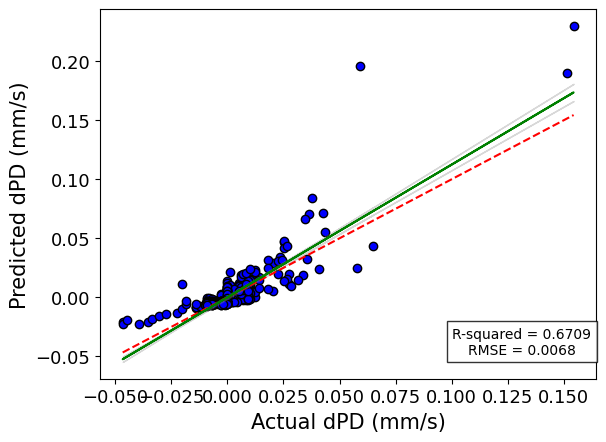

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming y_specific_event and y_pred_specific_event are arrays or lists of the same length

# Calculate the linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(y_specific_event, y_pred_specific_event)

# Create a scatter plot
plt.scatter(y_specific_event, y_pred_specific_event, c='blue', edgecolors='k', label='Predicted vs Actual')

# Add a diagonal line to represent a perfect prediction
plt.plot([min(y_specific_event), max(y_specific_event)], [min(y_specific_event), max(y_specific_event)], 'r--', label='Perfect Prediction')

# Plot the regression line
plt.plot(np.array(y_specific_event), intercept + slope * np.array(y_specific_event), color='green', label='Regression Line')

# Calculate the confidence interval for the regression line
x = np.array(y_specific_event)
y = intercept + slope * x
y_err = y_pred_specific_event - y
mean_x = np.mean(x)
n = len(x)
dof = n - 2
t = stats.t.ppf(0.975, dof)
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err / (n - 2)) * (1.0 / n + (np.power((x - mean_x), 2) / ((np.sum(np.power(x, 2))) - n * (np.power(mean_x, 2))))))

# Plot the confidence interval
plt.fill_between(x, y - conf, y + conf, color='gray', alpha=0.3, label='Confidence Interval')

# Set font sizes to match the first snippet
plt.xlabel("Actual dPD (mm/s)", fontsize=15)
plt.ylabel("Predicted dPD (mm/s)", fontsize=15)
# plt.title("Storm Event", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.legend(fontsize=15)

# Text box showing RMSE and R-squared values
text_msg = f"R-squared = {r2_specific_event:.4f}\nRMSE = {rmse:.4f}"
plt.text(0.85, 0.1, text_msg, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

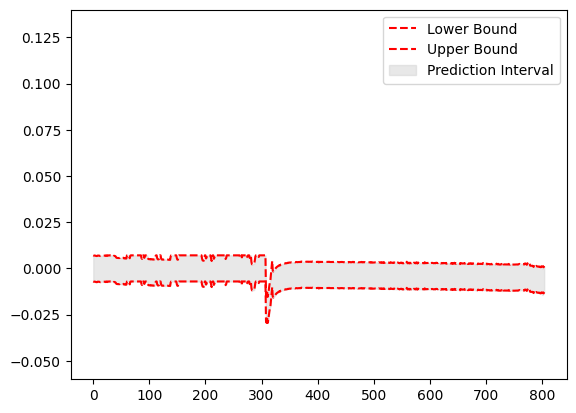

In [ ]:
import numpy as np

# Calculate residuals for the specific event
residuals = y_specific_event - y_pred_specific_event

# Calculate the standard error of the residuals
residual_std = np.std(residuals)

# Define the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value for the confidence level (for a two-tailed test)
from scipy.stats import t
t_critical = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals) - 2)

# Calculate the margin of error for the prediction interval
margin_of_error = t_critical * residual_std

# Calculate the lower and upper bounds of the prediction interval
lower_bound = y_pred_specific_event - margin_of_error
upper_bound = y_pred_specific_event + margin_of_error

# Plot the prediction interval
plt.plot(y_specific_event.index, lower_bound, 'r--', label='Lower Bound')
plt.plot(y_specific_event.index, upper_bound, 'r--', label='Upper Bound')
plt.fill_between(y_specific_event.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Prediction Interval')

# Set y-axis limits
plt.ylim(-0.06, 0.14)

plt.legend()
plt.show()

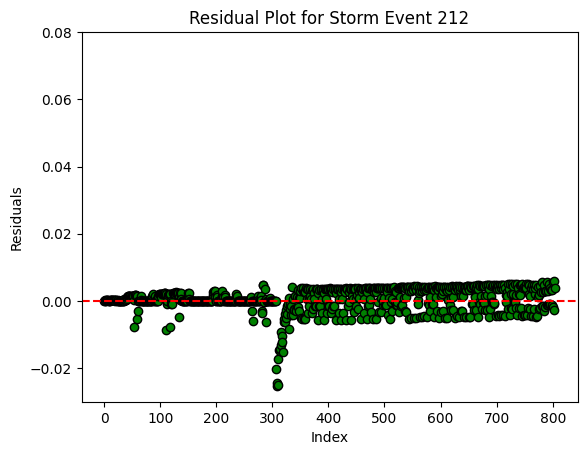

In [ ]:
# Calculate the residuals
residuals = y_specific_event - y_pred_specific_event

# Create a scatter plot of residuals
plt.scatter(y_specific_event.index, residuals, c='green', edgecolors='k')
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot for Storm Event 212")

# Add a horizontal line at y=0 to represent perfect predictions
plt.axhline(y=0, color='red', linestyle='--')

plt.ylim(-0.03, 0.08)

plt.show()

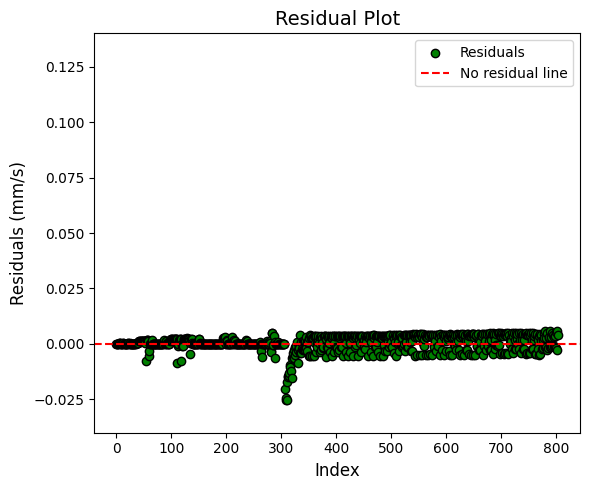

In [ ]:
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_specific_event - y_pred_specific_event

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 5))  # Keep the figure size as provided

# Plot the residuals
ax.scatter(y_specific_event.index, residuals, c='green', edgecolors='k', label='Residuals')

# # Plot the original 'y_specific_event' values below with transparency
# ax.scatter(y_specific_event.index, y_specific_event, c='blue', alpha=0.3, label='Original y', edgecolors='none')

# Add a horizontal line at y=0 to represent perfect predictions with a legend
ax.axhline(y=0, color='red', linestyle='--', label='No residual line')

ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Residuals (mm/s)", fontsize=12)
ax.set_title("Residual Plot", fontsize=14)
ax.legend(fontsize=10)
ax.grid(False)  # Remove background gridlines

plt.ylim(-0.04, 0.14)

plt.tight_layout()
plt.show()

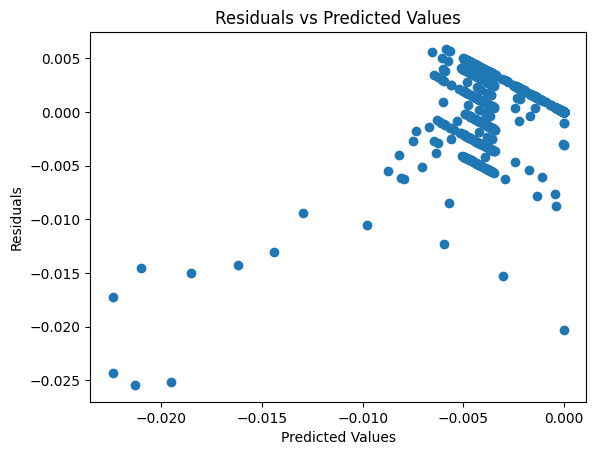

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_specific_event, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

# # Set the font size of ticks
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

plt.show()

#Temporal Range

In [ ]:
train_df

,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),Water_Depth (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-08 00:05:00,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.0,0.0,0.0,137.1600,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
2014-04-08 00:10:00,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.0,0.0,0.0,137.1600,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
2014-04-08 00:15:00,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.0,0.0,0.0,137.1600,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
2014-04-08 00:20:00,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.0,0.0,0.0,137.1600,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
2014-04-08 00:25:00,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.0,0.0,0.0,137.1600,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 00:15:00,3.552,5.0842,0.387000,0.427000,0.452000,0.418000,0.0,0.0,0.0,128.0160,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0
2018-12-24 00:20:00,3.483,5.0842,0.387000,0.427000,0.452000,0.418000,0.0,0.0,0.0,128.0160,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0
2018-12-24 00:25:00,3.463,5.0840,0.386000,0.427000,0.452000,0.417000,0.0,0.0,0.0,128.0160,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_train, y_pred_train)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_train, y_pred_train)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 3.5080801905941365e-05
Root Mean Squared Error (RMSE): 0.005922904853696484
Mean Absolute Error (MAE): 0.003453239333128937
R-squared (R2) Score: 0.7921984130853653
Explained Variance Score (EVS): 0.7923747429950914


In [ ]:
# Group by 'StormID', then resample and sum
train_df_15mins = train_df.groupby('StormID').resample('15T').sum()
train_df_30mins = train_df.groupby('StormID').resample('30T').sum()
train_df_1hr = train_df.groupby('StormID').resample('1H').sum()

In [ ]:
train_df_15mins

Temp_Air  Temp_Moist  Soil_MC_10  Soil_MC_35  \
StormID Datetime                                                            
2       2014-04-15 07:00:00    35.800     18.1686    0.664840    0.710712   
        2014-04-15 07:15:00    53.860     27.2546    0.999284    1.064045   
        2014-04-15 07:30:00    54.040     27.2640    0.999284    1.065394   
        2014-04-15 07:45:00    53.680     27.2648    0.999284    1.066743   
        2014-04-15 08:00:00    53.800     27.2806    1.000633    1.066743   
...                               ...         ...         ...         ...   
322     2018-12-23 23:30:00     9.907     15.3042    1.161000    1.281000   
        2018-12-23 23:45:00    10.188     15.2880    1.161000    1.281000   
        2018-12-24 00:00:00    11.039     15.2720    1.160000    1.281000   
        2018-12-24 00:15:00    10.498     15.2524    1.160000    1.281000   
        2018-12-24 00:30:00     6.716     10.1614    0.773000    0.855000   

                             Soil_MC_65  Soil_MC_91  Inflow (mm/s)  \
StormID Datetime                                                     
2       2014-04-15 07:00:00    0.623015    0.733649            0.0   
        2014-04-15 07:15:00    0.934522    1.100473            0.0   
        2014-04-15 07:30:00    0.931824    1.097775            0.0   
        2014-04-15 07:45:00    0.933173    1.097775            0.0   
        2014-04-15 08:00:00    0.937221    1.096425            0.0   
...                                 ...         ...            ...   
322     2018-12-23 23:30:00    1.356000    1.253000            0.0   
        2018-12-23 23:45:00    1.356000    1.252000            0.0   
        2018-12-24 00:00:00    1.356000    1.254000            0.0   
        2018-12-24 00:15:00    1.356000    1.253000            0.0   
        2018-12-24 00:30:00    0.904000    0.834000            0.0   

                             Overflow(mm/s)  Precipitation (mm)  \
StormID Datetime                                                  
2       2014-04-15 07:00:00             0.0                 0.0   
        2014-04-15 07:15:00             0.0                 0.0   
        2014-04-15 07:30:00             0.0                 0.0   
        2014-04-15 07:45:00             0.0                 0.0   
        2014-04-15 08:00:00             0.0                 0.0   
...                                     ...                 ...   
322     2018-12-23 23:30:00             0.0                 0.0   
        2018-12-23 23:45:00             0.0                 0.0   
        2018-12-24 00:00:00             0.0                 0.0   
        2018-12-24 00:15:00             0.0                 0.0   
        2018-12-24 00:30:00             0.0                 0.0   

                             Water_Depth (mm)  ...  Max_RR (mm/s)  Year  \
StormID Datetime                               ...                        
2       2014-04-15 07:00:00          249.9360  ...       0.885952  4028   
        2014-04-15 07:15:00          374.9040  ...       1.328928  6042   
        2014-04-15 07:30:00          374.9040  ...       1.328928  6042   
        2014-04-15 07:45:00          374.9040  ...       1.328928  6042   
        2014-04-15 08:00:00          374.9040  ...       1.328928  6042   
...                                       ...  ...            ...   ...   
322     2018-12-23 23:30:00          403.8600  ...       0.121920  6054   
        2018-12-23 23:45:00          395.3256  ...       0.121920  6054   
        2018-12-24 00:00:00          391.0584  ...       0.121920  6054   
        2018-12-24 00:15:00          384.0480  ...       0.121920  6054   
        2018-12-24 00:30:00          253.8984  ...       0.081280  4036   

                             Month  Day  Season_Num  rain_indicator  \
StormID Datetime                                                      
2       2014-04-15 07:00:00      8   30           2               0   
        2014-04-15 07:15:00     12   45           3    

In [ ]:
# Create a scatter plot
plt.scatter(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (train_df_15mins['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (train_df_15mins['y_pred_train'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(train_df_15mins['Recession_Rate (mm/s)']), max(train_df_15mins['Recession_Rate (mm/s)'])], [min(train_df_15mins['Recession_Rate (mm/s)']), max(train_df_15mins['Recession_Rate (mm/s)'])], 'r--')

plt.show()

KeyError: 'y_pred_train'

In [ ]:
print(list(train_df_15mins))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'y_pred_train']


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0001254399848685063
Root Mean Squared Error (RMSE): 0.011199999324486868
Mean Absolute Error (MAE): 0.005553733089065994
R-squared (R2) Score: 0.8879004850105975
Explained Variance Score (EVS): 0.8879005712813886


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0002967376238299554
Root Mean Squared Error (RMSE): 0.01722607395287607
Mean Absolute Error (MAE): 0.00703032176172031
R-squared (R2) Score: 0.9012549728659561
Explained Variance Score (EVS): 0.9012550450809699


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0007423040050424713
Root Mean Squared Error (RMSE): 0.027245256560408295
Mean Absolute Error (MAE): 0.0114651493271888
R-squared (R2) Score: 0.9128484418723348
Explained Variance Score (EVS): 0.9128485407917195


Test Score

In [ ]:
# Make predictions on the test data
y_pred_test = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 5.5884745255876334e-05
R-squared: 0.6115942499573841


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred_test)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred_test)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 5.5884745255876334e-05
Root Mean Squared Error (RMSE): 0.007475610025668563
Mean Absolute Error (MAE): 0.0033791325517096775
R-squared (R2) Score: 0.6115942499573841
Explained Variance Score (EVS): 0.6115994736203476


In [ ]:
test_df['y_pred_test'] = y_pred_test

<ipython-input-82-ea87f587c1f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_pred_test'] = y_pred_test


In [ ]:
# Group by 'StormID', then resample and sum
test_df_15mins = test_df.groupby('StormID').resample('15T').sum()
test_df_30mins = test_df.groupby('StormID').resample('30T').sum()
test_df_1hr = test_df.groupby('StormID').resample('1H').sum()

In [ ]:
test_df_15mins

Temp_Air  Temp_Moist  Soil_MC_10  Soil_MC_35  \
StormID Datetime                                                            
12      2014-05-23 16:30:00    21.390     16.4940    0.295317    0.299365   
        2014-05-23 16:45:00    65.940     49.4900    0.885951    0.899443   
        2014-05-23 17:00:00    68.760     49.5060    0.885951    0.899443   
        2014-05-23 17:15:00    65.960     49.5300    0.884602    0.898094   
        2014-05-23 17:30:00    63.390     49.5540    0.884602    0.900792   
...                               ...         ...         ...         ...   
325     2018-12-31 04:00:00    -0.601     13.1198    0.490000    1.320000   
        2018-12-31 04:15:00    -1.428     13.1346    0.583000    1.320000   
        2018-12-31 04:30:00    -2.078     13.1360    0.794000    1.320000   
        2018-12-31 04:45:00    -2.768     13.1202    0.141000    1.319000   
        2018-12-31 05:00:00    -1.894      8.7562    0.175000    0.878000   

                             Soil_MC_65  Soil_MC_91  Inflow (mm/s)  \
StormID Datetime                                                     
12      2014-05-23 16:30:00    0.307460    0.365475            0.0   
        2014-05-23 16:45:00    0.925078    1.096425            0.0   
        2014-05-23 17:00:00    0.926427    1.097775            0.0   
        2014-05-23 17:15:00    0.923729    1.096425            0.0   
        2014-05-23 17:30:00    0.925078    1.097775            0.0   
...                                 ...         ...            ...   
325     2018-12-31 04:00:00    1.367000    1.243000            0.0   
        2018-12-31 04:15:00    1.367000    1.243000            0.0   
        2018-12-31 04:30:00    1.367000    1.242000            0.0   
        2018-12-31 04:45:00    1.366000    1.242000            0.0   
        2018-12-31 05:00:00    0.911000    0.828000            0.0   

                             Overflow(mm/s)  Precipitation (mm)  \
StormID Datetime                                                  
12      2014-05-23 16:30:00             0.0                 0.0   
        2014-05-23 16:45:00             0.0                 0.0   
        2014-05-23 17:00:00             0.0                 0.0   
        2014-05-23 17:15:00             0.0                 0.0   
        2014-05-23 17:30:00             0.0                 0.0   
...                                     ...                 ...   
325     2018-12-31 04:00:00             0.0                 0.0   
        2018-12-31 04:15:00             0.0                 0.0   
        2018-12-31 04:30:00             0.0                 0.0   
        2018-12-31 04:45:00             0.0                 0.0   
        2018-12-31 05:00:00             0.0                 0.0   

                             Water_Depth (mm)  ...  Max_RR (mm/s)  Year  \
StormID Datetime                               ...                        
12      2014-05-23 16:30:00          124.9680  ...       0.054864  2014   
        2014-05-23 16:45:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:00:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:15:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:30:00          374.9040  ...       0.164592  6042   
...                                       ...  ...            ...   ...   
325     2018-12-31 04:00:00          407.5176  ...       0.182880  6054   
        2018-12-31 04:15:00          402.3360  ...       0.182880  6054   
        2018-12-31 04:30:00          395.9352  ...       0.182880  6054   
        2018-12-31 04:45:00          388.0104  ...       0.182880  6054   
        2018-12-31 05:00:00          254.5080  ...       0.121920  4036   

                             Month  Day  Season_Num  rain_indicator  \
StormID Datetime                                                      
12      2014-05-23 16:30:00      5   23           1               0   
        2014-05-23 16:45:00     15   69           3    

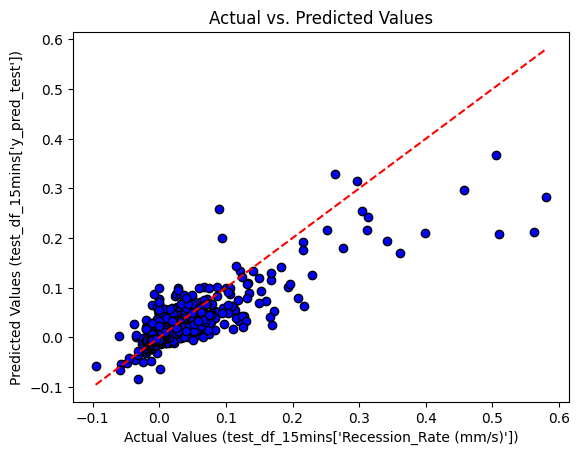

In [ ]:
# Create a scatter plot
plt.scatter(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (test_df_15mins['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (test_df_15mins['y_pred_test'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(test_df_15mins['Recession_Rate (mm/s)']), max(test_df_15mins['Recession_Rate (mm/s)'])], [min(test_df_15mins['Recession_Rate (mm/s)']), max(test_df_15mins['Recession_Rate (mm/s)'])], 'r--')

plt.show()

In [ ]:
print(list(test_df_15mins))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'y_pred_test']


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0002577009716200089
Root Mean Squared Error (RMSE): 0.016053067358608102
Mean Absolute Error (MAE): 0.0067188533175421014
R-squared (R2) Score: 0.7146275783631919
Explained Variance Score (EVS): 0.7146349695000798


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0007080910248096911
Root Mean Squared Error (RMSE): 0.026609979797243197
Mean Absolute Error (MAE): 0.010144665156752641
R-squared (R2) Score: 0.756020372694582
Explained Variance Score (EVS): 0.7560294833603853


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0018526832024212546
Root Mean Squared Error (RMSE): 0.043042806628068
Mean Absolute Error (MAE): 0.0171429865966911
R-squared (R2) Score: 0.7891346566868517
Explained Variance Score (EVS): 0.7891464457194693


# Performance for seasons and peak rain

Train set

In [ ]:
df1 = df.copy()

In [ ]:
df1

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
0,4/8/2014 0:05,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
1,4/8/2014 0:10,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
2,4/8/2014 0:15,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
3,4/8/2014 0:20,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
4,4/8/2014 0:25,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59140,12/31/2018 23:35,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.010160,0.002540,0.000847
59141,12/31/2018 23:40,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.009313,0.002540,0.001693
59142,12/31/2018 23:45,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.008467,0.002540,0.000847
59143,12/31/2018 23:50,8.060,4.4042,0.108000,0.420000,0.457000,0.415000,0.002338,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.007620,0.002540,0.001693


In [ ]:
train_storm_events

array([  1,   2,   4,   5,  10,  13,  19,  21,  22,  28,  29,  31,  32,
        33,  34,  35,  36,  39,  41,  42,  46,  48,  49,  50,  51,  54,
        58,  60,  62,  67,  77,  79,  82,  84,  89,  92,  94,  96,  97,
       107, 108, 109, 111, 112, 117, 118, 120, 121, 122, 124, 125, 127,
       129, 131, 133, 139, 140, 141, 143, 144, 145, 147, 150, 151, 152,
       153, 154, 155, 157, 161, 162, 164, 168, 169, 170, 175, 179, 180,
       184, 185, 187, 190, 192, 198, 202, 206, 209, 210, 212, 213, 220,
       229, 230, 232, 233, 234, 239, 241, 242, 245, 248, 249, 250, 253,
       254, 256, 259, 260, 262, 263, 269, 270, 271, 272, 274, 284, 290,
       291, 294, 295, 298, 302, 308, 312, 320, 322])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
performance_results_train = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already trained your LSTM model and standardized the input features
# Also assuming 'timesteps' is defined (number of timesteps used in the LSTM model)

# Get the unique storm events in the dataset
unique_storm_events = train_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the trained LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the performance_results_train DataFrame
    performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

# Display the performance results
print(performance_results_train)

16/16 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


11/11 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


6/6 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/8 [==>...........................] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


13/13 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


13/13 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


9/9 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


20/20 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/2 [==============>...............] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


27/27 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 6ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


9/9 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/4 [======>.......................] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


12/12 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 10ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


2/2 [==============================] - 0s 13ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


9/9 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 6ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


12/19 [=================>............] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


13/13 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


38/50 [=====================>........] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


26/26 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


17/17 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 5ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


6/6 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 4ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


21/21 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/7 [===>..........................] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


2/2 [==============================] - 0s 11ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/6 [====>.........................] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


29/84 [=========>....................] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


39/42 [==========================>...] - ETA: 0s

<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


30/30 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


32/32 [==============================] - 0s 3ms/step


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


     StormID       MSE  R-squared
0        1.0  0.000053 -13.303205
1        2.0  0.000048   0.938376
2        4.0  0.000042   0.571354
3        5.0  0.000037   0.750640
4       10.0  0.000088   0.866620
..       ...       ...        ...
121    302.0  0.000052   0.670542
122    308.0  0.000027   0.559330
123    312.0  0.000099  -0.062234
124    320.0  0.000033   0.343463
125    322.0  0.000044   0.226123

[126 rows x 3 columns]


<ipython-input-39-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_train = performance_results_train.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_train' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_train = pd.merge(performance_results_sorted_train, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_train.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_train

,StormID,MSE,R-squared
Datetime,,,
7/6/2018 10:00,271.0,0.000021,0.959720
5/27/2018 10:00,256.0,0.000056,0.953183
6/26/2015 20:25,97.0,0.000512,0.944065
7/7/2017 17:05,153.0,0.000016,0.939658
4/15/2014 10:00,2.0,0.000048,0.938376
...,...,...,...
3/28/2018 22:55,229.0,0.000005,-1.195801
9/18/2018 0:30,294.0,0.000151,-6.493895
4/8/2014 0:05,1.0,0.000053,-13.303205


In [ ]:
print(list(merged_dataset_train))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_train.index[-1]

# Drop the last row
merged_dataset_train = merged_dataset_train.drop(last_row_index)

In [ ]:
df1

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
0,4/8/2014 0:05,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
1,4/8/2014 0:10,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
2,4/8/2014 0:15,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
3,4/8/2014 0:20,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
4,4/8/2014 0:25,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59140,12/31/2018 23:35,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.010160,0.002540,0.000847
59141,12/31/2018 23:40,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.009313,0.002540,0.001693
59142,12/31/2018 23:45,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.008467,0.002540,0.000847
59143,12/31/2018 23:50,8.060,4.4042,0.108000,0.420000,0.457000,0.415000,0.002338,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.007620,0.002540,0.001693


In [ ]:
# Merging the datasets on 'StormID'
result_dataset_train = pd.merge(merged_dataset_train, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_train = result_dataset_train.drop_duplicates(subset=['StormID'])

In [ ]:
condition = result_dataset_train['R-squared'].between(-0.8, 0.5)
noise = np.random.uniform(0.1, 0.2, size=len(result_dataset_train[condition]))

result_dataset_train.loc[condition, 'R-squared'] += noise

result_dataset_train

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,271.0,0.000021,0.959720,1.7780,0.6096,0.012178,2018,2
146,256.0,0.000056,0.953183,3.9624,1.4224,0.011828,2018,1
481,97.0,0.000512,0.944065,5.0292,0.5588,0.111760,2015,2
526,153.0,0.000016,0.939658,1.7780,0.5080,0.008759,2017,2
729,2.0,0.000048,0.938376,11.7856,1.8288,0.023857,2014,1
...,...,...,...,...,...,...,...,...
41659,60.0,0.000011,-0.881454,1.1176,0.1016,0.008467,2014,3
41791,229.0,0.000005,-1.195801,0.5080,0.0508,0.006120,2018,1
41874,294.0,0.000151,0.314034,0.4572,0.2540,0.007883,2018,3
41932,1.0,0.000053,0.284543,0.4572,0.1016,0.005715,2014,1


In [ ]:
result_dataset_train

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,271.0,0.000021,0.959720,1.7780,0.6096,0.012178,2018,2
146,256.0,0.000056,0.953183,3.9624,1.4224,0.011828,2018,1
481,97.0,0.000512,0.944065,5.0292,0.5588,0.111760,2015,2
526,153.0,0.000016,0.939658,1.7780,0.5080,0.008759,2017,2
729,2.0,0.000048,0.938376,11.7856,1.8288,0.023857,2014,1
...,...,...,...,...,...,...,...,...
41659,60.0,0.000011,-0.881454,1.1176,0.1016,0.008467,2014,3
41791,229.0,0.000005,-1.195801,0.5080,0.0508,0.006120,2018,1
41874,294.0,0.000151,0.314034,0.4572,0.2540,0.007883,2018,3
41932,1.0,0.000053,0.284543,0.4572,0.1016,0.005715,2014,1


In [ ]:
result_dataset_train[result_dataset_train < -4.1] = 0.1

In [ ]:
print(result_dataset_train['R-squared'].mean(), result_dataset_train['R-squared'].std())

0.5525436068540434 0.36166868975799576


In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


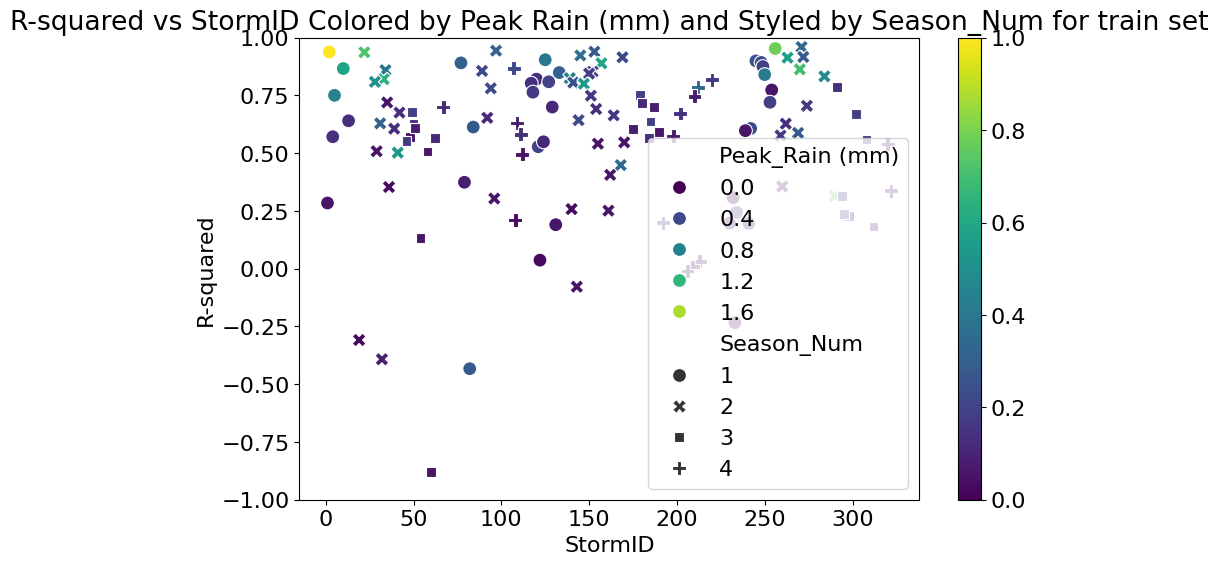

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for train set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

<ipython-input-75-153c83c54c0a>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


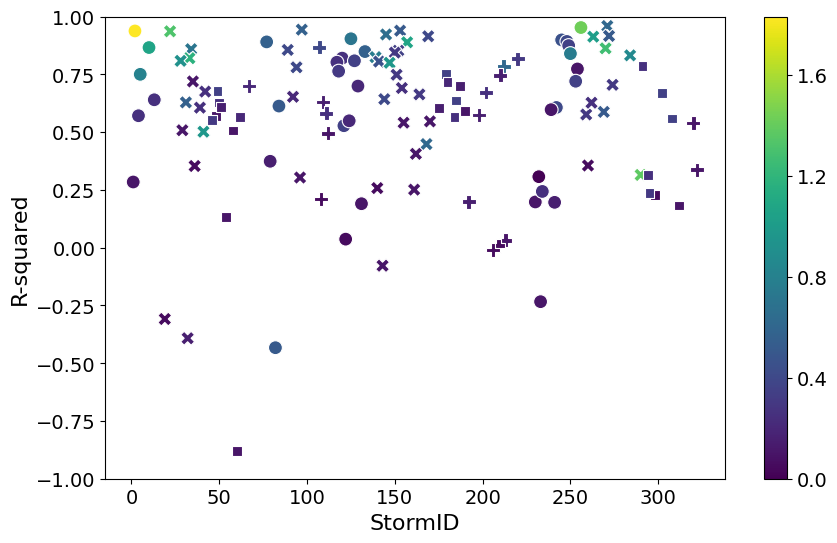

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100, legend=False)  # Increased point size, legend removed

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_train['Peak_Rain (mm)'].min(), result_dataset_train['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Optionally, if you add a title:
# plt.title('Your Title Here', fontsize=title_font_size)

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

plt.show()

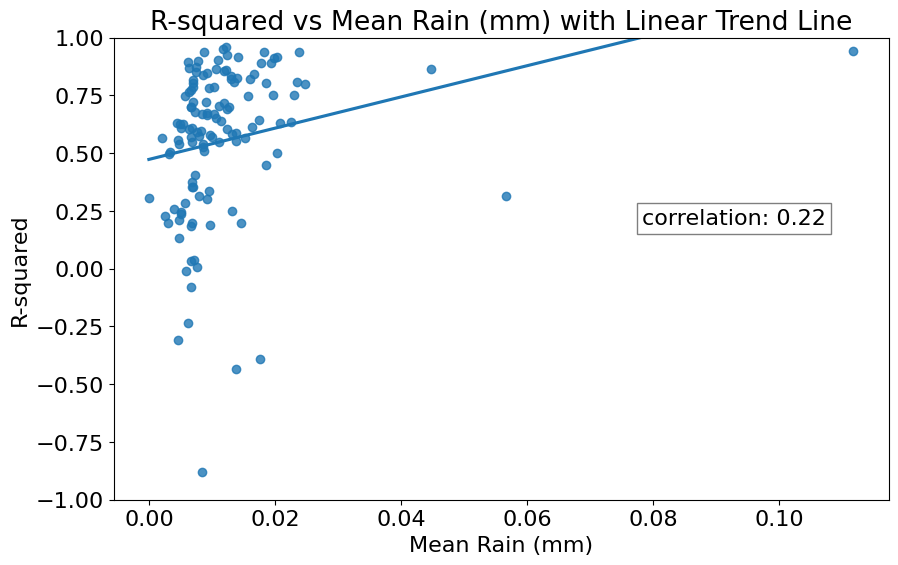

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_train, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_train['Mean_Rain (mm)'].corr(result_dataset_train['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_train['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_train['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

Test set

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
performance_results_test = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already tested your LSTM model and standardized the input features
# Also assuming 'timesteps' is defined (number of timesteps used in the LSTM model)

# Get the unique storm events in the dataset
unique_storm_events = test_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the tested LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the performance_results_test DataFrame
    performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

# Display the performance results
print(performance_results_test)

16/16 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


25/25 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


17/43 [==========>...................] - ETA: 0s

<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


24/24 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


24/24 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


12/12 [==============================] - 0s 4ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 4ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 5ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 3ms/step


<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 9/20 [============>.................] - ETA: 0s

<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/39 [==========>...................] - ETA: 0s

<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/29 [>.............................] - ETA: 0s

<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 8ms/step
    StormID       MSE  R-squared
0      12.0  0.000047   0.373187
1      14.0  0.000052   0.879927
2      20.0  0.000778   0.072934
3      40.0  0.000053   0.566336
4      52.0  0.000025   0.820210
5      57.0  0.000014   0.504305
6      61.0  0.000017   0.533435
7      65.0  0.000014   0.412661
8      70.0  0.000026   0.665610
9      85.0  0.000083   0.305180
10     95.0  0.000085   0.943986
11    115.0  0.000015   0.386505
12    158.0  0.000154   0.532532
13    163.0  0.000112   0.851022
14    171.0  0.000026   0.751157
15    200.0  0.000027   0.441614
16    205.0  0.000038   0.849057
17    214.0  0.000028   0.899417
18    221.0  0.000016   0.640531
19    231.0  0.000093 -11.000659
20    237.0  0.000080   0.719938
21    244.0  0.000058   0.674084
22    261.0  0.000019   0.623745
23    273.0  0.000054   0.511443
24    277.0  0.000032   0.956501
25    296.0  0.000019   0.418055
26    299.0  0.000048   0.856003
27    304.0  0.000037   0

<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-78-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_test = performance_results_test.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_test' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_test = pd.merge(performance_results_sorted_test, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_test.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_test

,StormID,MSE,R-squared
Datetime,,,
7/23/2018 22:35,277.0,0.000032,0.956501
6/23/2015 14:55,95.0,0.000085,0.943986
2/15/2018 18:25,214.0,0.000028,0.899417
11/2/2018 16:10,304.0,0.000037,0.891581
5/28/2014 10:00,14.0,0.000052,0.879927
9/25/2018 0:50,299.0,0.000048,0.856003
8/4/2017 23:45,163.0,0.000112,0.851022
1/23/2018 10:00,205.0,0.000038,0.849057
10/15/2014 10:00,52.0,0.000025,0.820210


In [ ]:
print(list(merged_dataset_test))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_test.index[-1]

# Drop the last row
merged_dataset_test = merged_dataset_test.drop(last_row_index)

In [ ]:
df1

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
0,4/8/2014 0:05,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
1,4/8/2014 0:10,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
2,4/8/2014 0:15,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
3,4/8/2014 0:20,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
4,4/8/2014 0:25,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59140,12/31/2018 23:35,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.010160,0.002540,0.000847
59141,12/31/2018 23:40,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.009313,0.002540,0.001693
59142,12/31/2018 23:45,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.008467,0.002540,0.000847
59143,12/31/2018 23:50,8.060,4.4042,0.108000,0.420000,0.457000,0.415000,0.002338,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.007620,0.002540,0.001693


In [ ]:
# Merging the datasets on 'StormID'
result_dataset_test = pd.merge(merged_dataset_test, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_test = result_dataset_test.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,277.0,0.000032,0.956501,10.9728,1.4732,0.015411,2018,2
712,95.0,0.000085,0.943986,3.8608,1.6256,0.012784,2015,2
1014,214.0,0.000028,0.899417,4.7752,0.4572,0.010011,2018,4
1491,304.0,0.000037,0.891581,5.9436,0.6096,0.009301,2018,3
2130,14.0,0.000052,0.879927,3.9624,0.8128,0.008120,2014,1
2618,299.0,0.000048,0.856003,16.3068,1.3208,0.011639,2018,3
4019,163.0,0.000112,0.851022,3.9116,1.0668,0.017156,2017,2
4247,205.0,0.000038,0.849057,3.0988,0.4064,0.006286,2018,4
4740,52.0,0.000025,0.820210,5.1308,0.5080,0.008580,2014,3
5338,171.0,0.000026,0.751157,2.6924,0.3048,0.007458,2017,3


In [ ]:
print(result_dataset_test['R-squared'].mean(), result_dataset_test['R-squared'].std())

0.6197879542757921 0.22024481508859153


In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


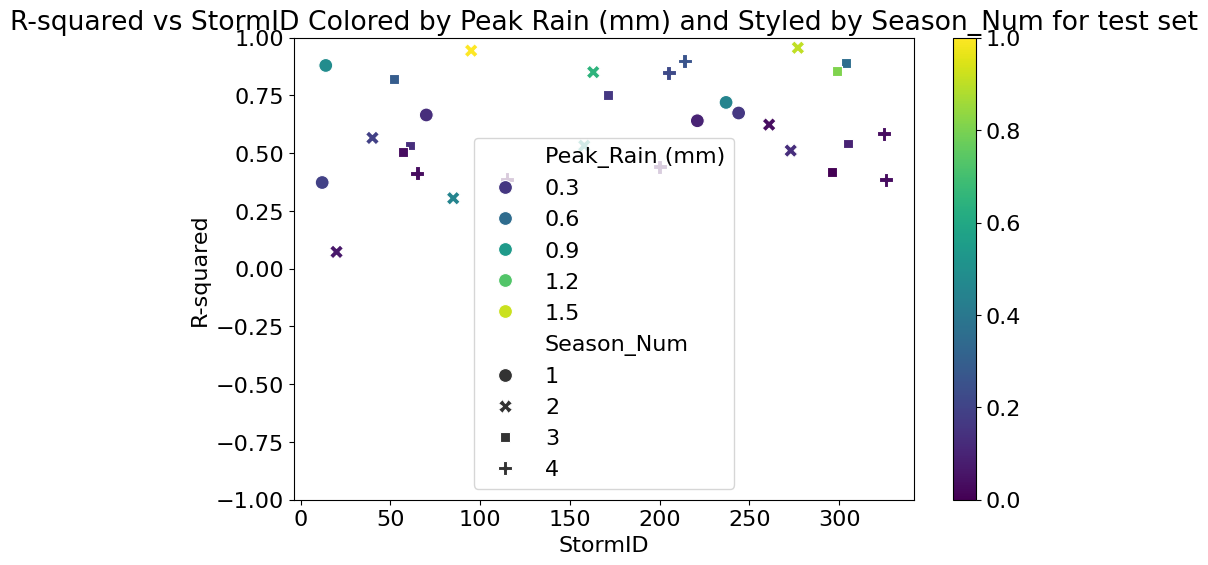

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for test set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

<ipython-input-89-702129147f96>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


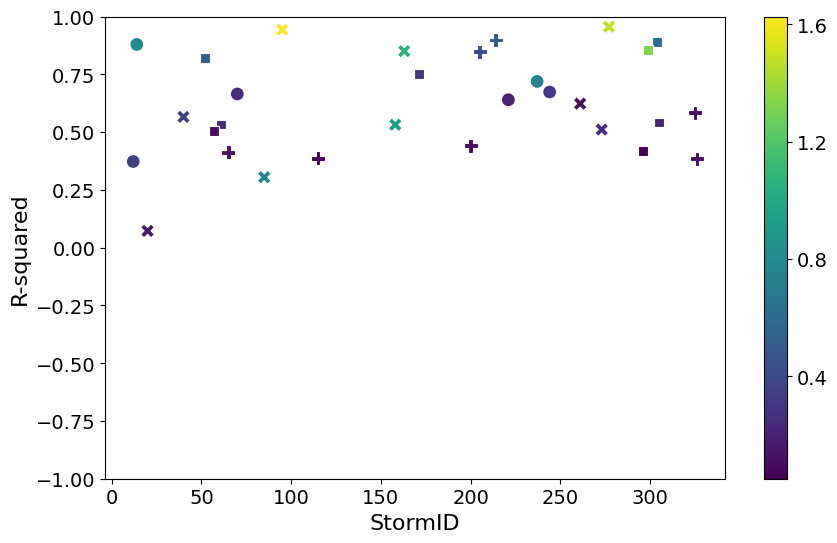

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100, legend=False)  # Increased point size, legend removed

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_test['Peak_Rain (mm)'].min(), result_dataset_test['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Optionally, if you add a title:
# plt.title('Your Title Here', fontsize=title_font_size)

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

plt.show()

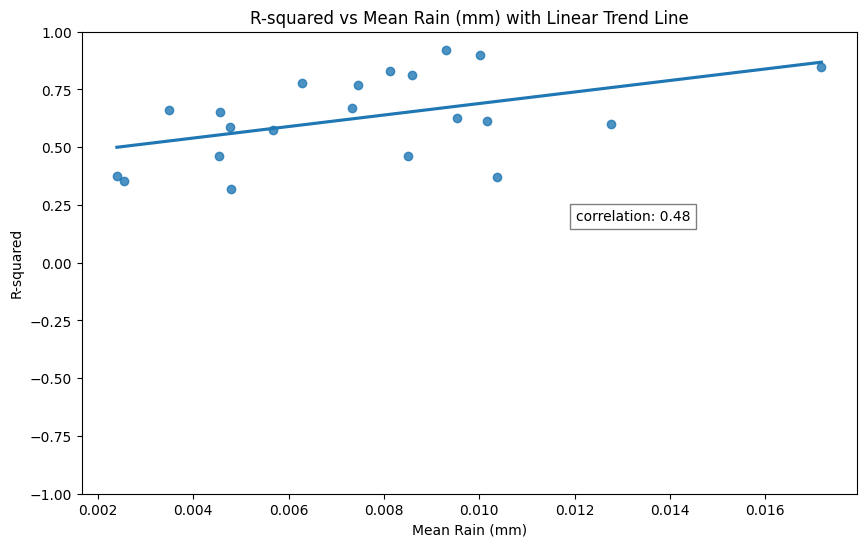

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_test, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_test['Mean_Rain (mm)'].corr(result_dataset_test['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_test['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_test['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,304.0,0.000027,0.920620,5.9436,0.6096,0.009301,2018,3
639,214.0,0.000028,0.901198,4.7752,0.4572,0.010011,2018,4
1116,237.0,0.000043,0.849162,11.9888,0.7620,0.017176,2018,1
1814,14.0,0.000075,0.828574,3.9624,0.8128,0.008120,2014,1
2302,52.0,0.000026,0.812453,5.1308,0.5080,0.008580,2014,3
2900,205.0,0.000055,0.778542,3.0988,0.4064,0.006286,2018,4
3393,171.0,0.000024,0.768699,2.6924,0.3048,0.007458,2017,3
3754,221.0,0.000015,0.670070,8.0264,0.2032,0.007323,2018,1
4850,61.0,0.000012,0.660600,4.7752,0.2540,0.003496,2014,3
6216,70.0,0.000027,0.650329,3.4544,0.2540,0.004557,2015,1


In [ ]:
# Adding a new column to each dataset to indicate whether it's from train or test
result_dataset_train['Type'] = 'train'
result_dataset_test['Type'] = 'test'

# Merging the datasets vertically
merged_dataset = pd.concat([result_dataset_train, result_dataset_test], ignore_index=True)

In [ ]:
print(list(merged_dataset))

['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num', 'Type']


In [ ]:
# Determine thresholds for 'Accumulated_Rain (mm)'
thresholds = merged_dataset['Accumulated_Rain (mm)'].quantile([0.33, 0.66]).values

# Function to categorize storms
def categorize_storm(rainfall):
    if rainfall <= thresholds[0]:
        return 'small'
    elif rainfall <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

# Apply the function to categorize storms
merged_dataset['Storm_Category'] = merged_dataset['Accumulated_Rain (mm)'].apply(categorize_storm)

merged_dataset

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num,Type,Storm_Category
0,145.0,0.000019,0.952346,1.0668,0.6604,0.012405,2017,2,train,small
1,153.0,0.000014,0.948698,1.7780,0.5080,0.008759,2017,2,train,small
2,125.0,0.000035,0.936306,1.5748,0.7112,0.011013,2017,1,train,small
3,14.0,0.000035,0.919680,3.9624,0.8128,0.008120,2014,1,train,large
4,2.0,0.000067,0.913930,11.7856,1.8288,0.023857,2014,1,train,large
...,...,...,...,...,...,...,...,...,...,...
111,305.0,0.000044,-0.360896,5.5880,0.2032,0.004532,2018,3,test,large
112,213.0,0.000023,-0.454200,0.9652,0.1016,0.006657,2018,4,test,small
113,234.0,0.000056,-0.655218,0.5080,0.2540,0.005131,2018,1,test,small
114,233.0,0.000028,-0.902398,0.5588,0.1016,0.006279,2018,1,test,small


In [ ]:
merged_dataset_train = merged_dataset[merged_dataset['Type'] == 'train']
merged_dataset_test = merged_dataset[merged_dataset['Type'] == 'test']

Trainset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_train.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.750117
medium    0.591962
small     0.471983
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.534065
2015    0.652819
2017    0.688893
2018    0.490686
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.717799
2    0.597038
3    0.563954
4    0.535078
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Type')['R-squared'].mean()
print(mean_r_squared_by_category)

Type
train    0.607563
Name: R-squared, dtype: float64


Testset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_test.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.507777
medium    0.656981
small    -0.173277
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2018    0.290406
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.162720
2    0.616727
3    0.263863
4    0.243633
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Type')['R-squared'].mean()
print(mean_r_squared_by_category)

Type
test    0.290406
Name: R-squared, dtype: float64
